# check transformer block

In [1]:
from torchinfo import summary
import torch
import matplotlib.pyplot as plt 
from transformer import HandposeEncoder
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
en = HandposeEncoder(256, 24,32,24,10,24,8,num_layers=3).to(device)#(q_dimentoins, kv_dimentoins,h_src,w_src,batch,c_src, num_heads, forward_dimentions, dropout,num_layers)
src = torch.rand(10, 24, 32, 24).to(device)
support_embed = torch.rand(10, 21, 256).to(device)
query_embed = en(src, support_embed)
print(query_embed.shape)


torch.Size([21, 10, 256])


# check the fusion blocks

torch.Size([1, 21, 32, 24])
torch.Size([21, 21])


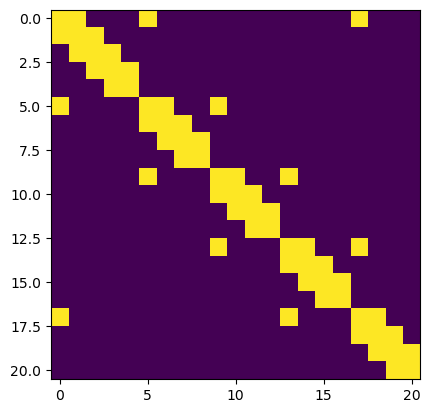

Layer (type:depth-idx)                   Output Shape              Param #
CrossKeypointsFusion                     [1, 21, 32, 24]           --
├─Conv2d: 1-1                            [1, 21, 32, 24]           441
├─BatchNorm2d: 1-2                       [1, 21, 32, 24]           42
├─ReLU: 1-3                              [1, 21, 32, 24]           --
Total params: 483
Trainable params: 483
Non-trainable params: 0
Total mult-adds (M): 0.34
Input size (MB): 0.06
Forward/backward pass size (MB): 0.26
Params size (MB): 0.00
Estimated Total Size (MB): 0.32

In [2]:
from FusionBlocks import CrossKeypointsFusion
from torchinfo import summary
import torch
import matplotlib.pyplot as plt 

# test the CrossKeypointsFusion
x = torch.randn(1, 21, 32, 24)
cross_keypoints_fusion = CrossKeypointsFusion(21, trainable=True, init_adjacent_matrix=True)
y = cross_keypoints_fusion(x)
print(y.shape)
wt = cross_keypoints_fusion.conv.weight.data[:,:,0,0]
print(wt.shape)
plt.imshow(wt)
plt.show()

# print(cross_keypoints_fusion.conv.weight.requires_grad)
summary(cross_keypoints_fusion, input_size=(1, 21, 32, 24))

In [7]:
# test the TemporalKeypointsFusion
from FusionBlocks import TemporalKeypointsFusion
num_history = 0
num_blocks = 3
current_keypoints_feature = torch.randn(1, 1, 21, 32*24)
previous_keypoints_features = torch.randn(1, num_history, 21, 32*24)
temporal_keypoints_fusion = TemporalKeypointsFusion(num_history, num_blocks)
fused_keypoints_features = temporal_keypoints_fusion(current_keypoints_feature, previous_keypoints_features)
print(fused_keypoints_features.shape)

torch.Size([1, 1, 21, 768])


# check mobile block

In [1]:
from MobileNetEncoder import MobileEncoder
from torchinfo import summary
import torch

interverted_residual_setting = [
        # t, c, n, s
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        # [6, 96, 3, 1],
        # [6, 160, 3, 2],
        # [6, 320, 1, 1],
    ]
spatial_encoder = MobileEncoder(input_channel = 1, last_channel = 128 , width_mult=1., interverted_residual_setting =interverted_residual_setting, upsample_scale_factor = 10)

print("TT:")
print(spatial_encoder.get_output_shape( batch_size = 1, input_channel = 1, h = 24, w = 32))
_, _,w,h = spatial_encoder.get_output_shape( batch_size = 1, input_channel = 1, h = 24, w = 32)
print(w,h)

summary(spatial_encoder, input_size=(1, 1, 24, 32))


TT:
torch.Size([1, 128, 15, 20])
15 20


Layer (type:depth-idx)                   Output Shape              Param #
MobileEncoder                            [1, 128, 15, 20]          --
├─Upsample: 1-1                          [1, 1, 240, 320]          --
├─Sequential: 1-2                        [1, 128, 15, 20]          --
│    └─Sequential: 2-1                   [1, 1, 120, 160]          --
│    │    └─Conv2d: 3-1                  [1, 1, 120, 160]          9
│    │    └─BatchNorm2d: 3-2             [1, 1, 120, 160]          2
│    │    └─ReLU6: 3-3                   [1, 1, 120, 160]          --
│    └─InvertedResidual: 2-2             [1, 16, 120, 160]         --
│    │    └─Sequential: 3-4              [1, 16, 120, 160]         59
│    └─InvertedResidual: 2-3             [1, 24, 60, 80]           --
│    │    └─Sequential: 3-5              [1, 24, 60, 80]           5,136
│    └─InvertedResidual: 2-4             [1, 24, 60, 80]           --
│    │    └─Sequential: 3-6              [1, 24, 60, 80]           8,832
│    └─Inve

In [2]:
interverted_residual_setting = [
    # t, c, n, s
    [1, 4, 1, 1],
    [6, 8, 2, 1],
    [6, 16, 3, 2],
    [6, 21, 4, 1],
    # [6, 96, 3, 1],
    # [6, 160, 3, 2],
    # [6, 320, 1, 1],
]
keypoints_encoder = MobileEncoder(input_channel = 1, last_channel = 21 , width_mult=1., interverted_residual_setting =interverted_residual_setting, upsample_scale_factor = 1)

print("TT:")
print(keypoints_encoder.get_output_shape( batch_size = 1, input_channel = 1, h = 24, w = 32))
_, _,w,h = keypoints_encoder.get_output_shape( batch_size = 1, input_channel = 1, h = 24, w = 32)
print(w,h)


summary(keypoints_encoder, input_size=(1, 1, 24, 32))

TT:
torch.Size([1, 21, 6, 8])
6 8


Layer (type:depth-idx)                   Output Shape              Param #
MobileEncoder                            [1, 21, 6, 8]             --
├─Sequential: 1-1                        [1, 21, 6, 8]             --
│    └─Sequential: 2-1                   [1, 1, 12, 16]            --
│    │    └─Conv2d: 3-1                  [1, 1, 12, 16]            9
│    │    └─BatchNorm2d: 3-2             [1, 1, 12, 16]            2
│    │    └─ReLU6: 3-3                   [1, 1, 12, 16]            --
│    └─InvertedResidual: 2-2             [1, 4, 12, 16]            --
│    │    └─Sequential: 3-4              [1, 4, 12, 16]            23
│    └─InvertedResidual: 2-3             [1, 8, 12, 16]            --
│    │    └─Sequential: 3-5              [1, 8, 12, 16]            616
│    └─InvertedResidual: 2-4             [1, 8, 12, 16]            --
│    │    └─Sequential: 3-6              [1, 8, 12, 16]            1,408
│    └─InvertedResidual: 2-5             [1, 16, 6, 8]             --
│    │    └─S

In [4]:
import torch    
import torch.nn as nn

m = nn.Linear(20, 3)
input = torch.randn(12,21 , 20)
output = m(input)
print(output.size())

torch.Size([12, 21, 3])
